# Landsat upgrade

1. create list of locations/times for satellite imagery download
2. download sentinel image and cut into standard 400 pix by 400 pix tiles
3. download matching landsat image
4. save figures to be used in GAN training model

In [15]:
## Datacube connection
dc = datacube.Datacube(app="Sentinel_2")

In [3]:
## read batch 1
batch_1_list = utilities.get_batch(4)
print(len(batch_1_list), "entries like ")
print(batch_1_list[0])
print("in batch 1")


In [16]:

## Show extra printouts?
verbose=False

In [21]:


def chipper(chip):
    """
        download and create image from sentinel and landsat products
        INPUT:
            chip: [[id,'YYYY-MM',(lon0,lon1),lat0,lat1],[...]]
    """
    flag = False
    clip_frac=0.05
    uid = chip[0]
    time = chip[1]
    x = chip[2]
    y = chip[3]
    batch= chip[4]
    
    ## Create a query object
    if verbose:
        print("INFO: chipper called:")
        print("INFO: x, y, time: ",x,y,time)
        
    query = {
        "x": x,
        "y": y,
        "time": time,
        "output_crs": "EPSG:3577",
        "resolution": (-10, 10),
        "group_by": "solar_day",
    }
    
    ## download ard granule
    ds = dc.load(
        product=sentinel_product,
        measurements = sentinel_bands,
        **query
    )
    
    if verbose:
        print(ds)
    
    # Only get images if sentinel has some
    if len(ds.sizes)==0:
        print("WARNING: NO DATA FOR TIME RANGE",time)
    else:
        # We have data, iterate over available time steps
        for i in range(len(ds.time)):
            ## READ RGB into numpy array [y,x,channel]
            img = np.moveaxis(ds[['nbart_red', 'nbart_green', 'nbart_blue']].isel(time=i).to_array().values,0,2)
            if verbose:
                print("INFO: downloaded data details:")
                print("INFO: shape, type: ",img.shape, type(img))
                print("INFO: min, max: ", np.min(img), np.max(img))
            
            ## Normalise image to uint
            img = utilities.jesse_normalise(img)
            
            ## Check for too much white or black (probably cloud/missing)
            if np.sum(img==0) > clip_frac*np.size(img):
                continue
            if np.sum(img==255) > clip_frac*np.size(img):
                continue
            
            ## Cut to 400x400
            n_y,n_x,_ = np.shape(img)
            dim_max=400
            assert n_x > dim_max, "ERR: X DIM IS < 400"
            assert n_y > dim_max, "ERR: Y DIM IS < 400"
            img_cut = img[:dim_max,:dim_max,:]
            
            ## Save figure
            # no longer saving flagged images
            fname=imgname%(batch,uid,"sentinel",i)
            imageio.imwrite(fname,img_cut)
            print("INFO: Saved figure: ",fname)
            
                

In [7]:
## Test chipper function
batch_1_list = get_batch(1)
print(batch_1_list[:3])
print(len(batch_1_list), "items in batch 1")
chipper(batch_1_list[0])


[[2, '2018-05', (151.044324993003, 151.09532499300298), (-26.6923060270002, -26.7263060270002)], [5, '2019-04', (149.744324993003, 149.795324993003), (-26.6923060270002, -26.7263060270002)], [6, '2017-04', (144.844324993002, 144.895324993002), (-26.6923060270002, -26.7263060270002)]]
2518 items in batch 1
INFO: Saved figure:  batch1/0002_sentinel_00.png
INFO: Saved figure:  batch1/0002_sentinel_01.png
INFO: Saved figure:  batch1/0002_sentinel_02.png
INFO: Saved figure:  batch1/0002_sentinel_03.png
INFO: Saved figure:  batch1/0002_sentinel_04.png


In [22]:
batch_4_list = utilities.get_batch(4)
uidlist = [l[0] for l in batch_4_list]
uidlist.index(95)

chipper(batch_4_list[20])

INFO: Saved figure:  batch1/0095_sentinel_01.png
INFO: Saved figure:  batch1/0095_sentinel_02.png


In [8]:



## there's like 16 processes available for use?
with Pool() as pool:
    ## run chipper function with list of chips  as input argument
    ## each function call can be done independently
    pool.map(chipper, batch_4_list[:100])

print("INFO:FINISHED")


INFO: Saved figure:  batch1/0943_sentinel_00.png
INFO: Saved figure:  batch1/0798_sentinel_00.png
INFO: Saved figure:  batch1/0798_sentinel_01.png
INFO: Saved figure:  batch1/0763_sentinel_00.png
INFO: Saved figure:  batch1/0605_sentinel_00.png
INFO: Saved figure:  batch1/0975_sentinel_00.png
INFO: Saved figure:  batch1/0605_sentinel_01.png
INFO: Saved figure:  batch1/0975_sentinel_01.png
INFO: Saved figure:  batch1/0634_sentinel_00.png
INFO: Saved figure:  batch1/0634_sentinel_01.png
INFO: Saved figure:  batch1/0876_sentinel_00.png
INFO: Saved figure:  batch1/0876_sentinel_01.png
INFO: Saved figure:  batch1/0949_sentinel_00.png
INFO: Saved figure:  batch1/0880_sentinel_00.png
INFO: Saved figure:  batch1/0613_sentinel_01.png
INFO: Saved figure:  batch1/0831_sentinel_00.png
INFO: Saved figure:  batch1/0831_sentinel_01.png
INFO: Saved figure:  batch1/0903_sentinel_00.png
INFO: Saved figure:  batch1/0903_sentinel_01.png
INFO: Saved figure:  batch1/0903_sentinel_02.png
INFO: Saved figure: 

OperationalError: (psycopg2.OperationalError) SSL error: decryption failed or bad record mac

[SQL: SELECT agdc.dataset_type.id, agdc.dataset_type.name, agdc.dataset_type.metadata, agdc.dataset_type.metadata_type_ref, agdc.dataset_type.definition, agdc.dataset_type.added, agdc.dataset_type.added_by 
FROM agdc.dataset_type ORDER BY agdc.dataset_type.name ASC]

In [6]:

batch=2
batch_2_list = utilities.get_batch(2)

pool = Pool()
pool.map(chipper, batch_2_list)
pool.close()
print("INFO:FINISHED")
print()
print()


INFO: Saved figure:  batch2/4774_sentinel_00.png
INFO: Saved figure:  batch2/2999_sentinel_00.png
INFO: Saved figure:  batch2/3942_sentinel_00.png
INFO: Saved figure:  batch2/2999_sentinel_01.png
INFO: Saved figure:  batch2/3942_sentinel_01.png
INFO: Saved figure:  batch2/4591_sentinel_00.png
INFO: Saved figure:  batch2/3505_sentinel_00.png
INFO: Saved figure:  batch2/3505_sentinel_01.png
INFO: Saved figure:  batch2/2531_sentinel_00.png
INFO: Saved figure:  batch2/2531_sentinel_01.png
INFO: Saved figure:  batch2/3630_sentinel_00.png
INFO: Saved figure:  batch2/4591_sentinel_01.png
INFO: Saved figure:  batch2/3630_sentinel_01.png
INFO: Saved figure:  batch2/3630_sentinel_02.png
INFO: Saved figure:  batch2/3633_sentinel_00.png
INFO: Saved figure:  batch2/3008_sentinel_00.png
INFO: Saved figure:  batch2/4780_sentinel_00.png
INFO: Saved figure:  batch2/4780_sentinel_01.png
INFO: Saved figure:  batch2/4780_sentinel_02.png
INFO: Saved figure:  batch2/4293_sentinel_00.png
INFO: Saved figure: 

OperationalError: (psycopg2.OperationalError) SSL error: wrong version number

[SQL: SELECT agdc.dataset_type.id, agdc.dataset_type.name, agdc.dataset_type.metadata, agdc.dataset_type.metadata_type_ref, agdc.dataset_type.definition, agdc.dataset_type.added, agdc.dataset_type.added_by 
FROM agdc.dataset_type ORDER BY agdc.dataset_type.name ASC]

In [1]:
import glob, os
from pathlib import Path
import shutil
from PIL import Image

downscaling = Image.BILINEAR
# could use ANTIALIAS, BICUBIC, NEAREST, BILINEAR
# BILINEAR seems to be the worst, so we use that

## Loop through images, add blurred image for each sentinel image

def blurrify(fname, res=(160,160), newname="blurred"):
    """
        turn fname into image with about 1/3 of the horizontal resolution
    """
    # open image
    im = Image.open(fname)
    
    # first resize
    size0=(150,150)
    im_resized0 = im.resize(size0, downscaling)
    
    # second resize
    # upscale to 160x160
    im_resized = im_resized0.resize(res, downscaling)
    # new name
    lr_image = fname.replace("sentinel",newname)
    im_resized.save(lr_image, "PNG")
    print("INFO: saved figure: ",lr_image)



In [4]:
from glob import glob
import os

batch=2
sentinel_list = glob("batch%d/*_sentinel_*"%batch)
sentinel_list.sort()
#print(sentinel_list)
for fname in sentinel_list:
    blurrify(fname, res=(80,80), newname="verybad")

for fname in sentinel_list:
    blurrify(fname, res=(160,160), newname="blurred")



INFO: saved figure:  batch2/2531_verybad_00.png
INFO: saved figure:  batch2/2531_verybad_01.png
INFO: saved figure:  batch2/2541_verybad_00.png
INFO: saved figure:  batch2/2541_verybad_01.png
INFO: saved figure:  batch2/2545_verybad_01.png
INFO: saved figure:  batch2/2549_verybad_00.png
INFO: saved figure:  batch2/2549_verybad_01.png
INFO: saved figure:  batch2/2549_verybad_02.png
INFO: saved figure:  batch2/2555_verybad_00.png
INFO: saved figure:  batch2/2555_verybad_01.png
INFO: saved figure:  batch2/2556_verybad_00.png
INFO: saved figure:  batch2/2560_verybad_00.png
INFO: saved figure:  batch2/2564_verybad_00.png
INFO: saved figure:  batch2/2564_verybad_01.png
INFO: saved figure:  batch2/2564_verybad_02.png
INFO: saved figure:  batch2/2566_verybad_00.png
INFO: saved figure:  batch2/2566_verybad_01.png
INFO: saved figure:  batch2/2576_verybad_00.png
INFO: saved figure:  batch2/2576_verybad_01.png
INFO: saved figure:  batch2/2579_verybad_00.png
INFO: saved figure:  batch2/2579_verybad

In [86]:

# Zip the images folder
foldername = "batch%d"%batch
!tar cvzf zipname.tar.gz $foldername
clear_output()

# Make zip files up to 50m large
#tar -czf - batch1/ | split -b 50m - batch1parts.tar.gz.
# Then extract them
#cat batch1parts.tar.gz.* | tar xzf -

# Manual Filtering

1. Download batch folder
2. Manually remove cloud affected and weird images
3. upload these into new folder batchx_filtered



In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def show_images(uid, r1="sen*", r2="blu*"):
    fnames_s = glob("batch%d_filtered/%04d_%s"%(batch,uid,r1))
    fnames_l = glob("batch%d_filtered/%04d_%s"%(batch,uid,r2))
    # Show uid images in a grid
    f,axes = plt.subplots(2,3,figsize=[16,14])
    
    ## Loop over landsat images
    for i,fname in enumerate(fnames_l):
        if i==3: break
        plt.sca(axes[0,i])
        plt.imshow(mpimg.imread(fname))
        plt.title(fname)
        
    
    ## loop over sentinel images
    for i,fname in enumerate(fnames_s):
        if i==3: break
        plt.sca(axes[1,i])    
        plt.imshow(mpimg.imread(fname))
        plt.title(fname)
    
    for ax in axes.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels("")
        ax.set_yticklabels("")
    plt.tight_layout()



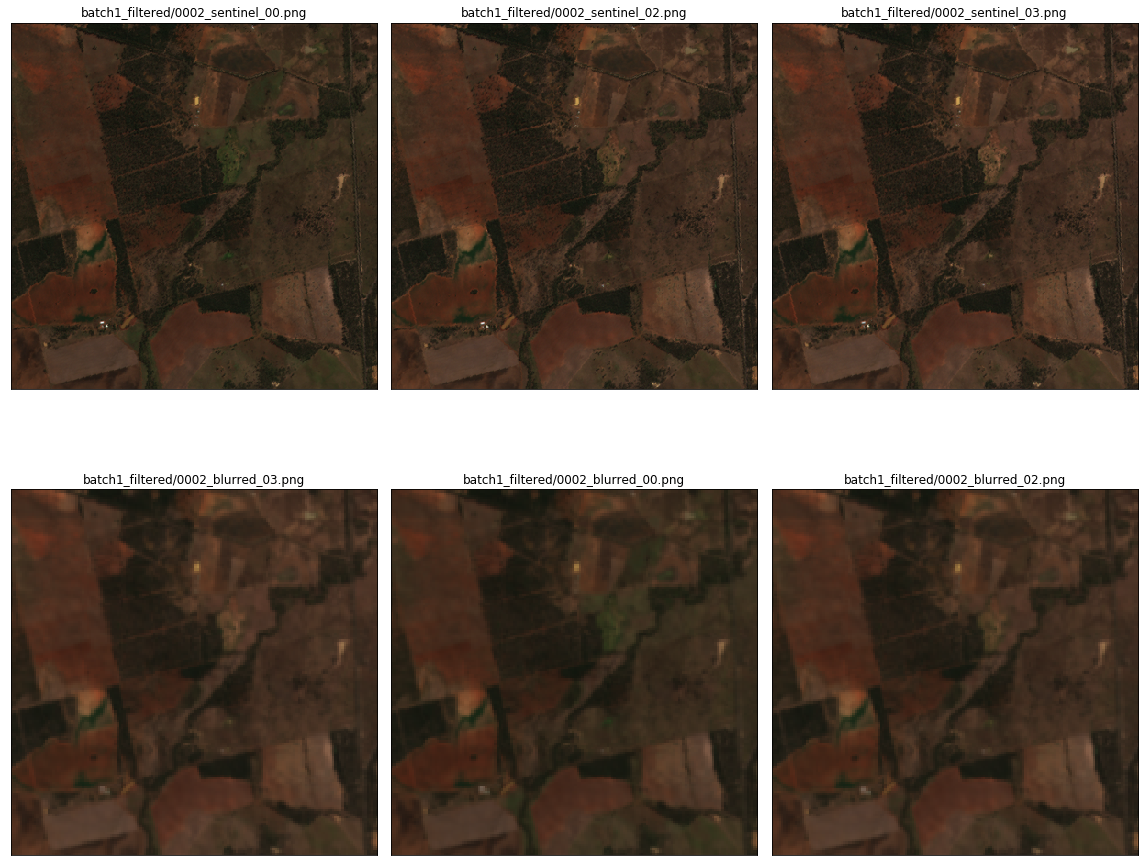

In [18]:
show_images(2,r1="blu*",r2="sen*")

In [92]:
#show_images(7,"blu*","ant*")

In [94]:
#show_images(7,"blu*","sen*")

<img src="" />

In [95]:
#show_images(7,"ant*","lan*")

In [12]:
verbose=False

def chipper_160(chip):
    """
        download and create image from sentinel and landsat products
        INPUT:
            chip: [[id,'YYYY-MM',(lon0,lon1),lat0,lat1],[...]]
    """
    clip_frac = 0.05
    flag = False
    uid = chip[0]
    time = chip[1]
    x = chip[2]
    y = chip[3]
    batch=chip[4]
    
    ## Create a query object
    if verbose:
        print("INFO: chipper called:")
        print("INFO: x, y, time: ",x,y,time)
        
    query = {
        "x": x,
        "y": y,
        "time": time,
        "output_crs": "EPSG:3577",
        "resolution": (-10, 10),
        "group_by": "solar_day",
    }
    
    ## download ard granule
    ds = dc.load(
        product=sentinel_product,
        measurements = sentinel_bands,
        **query
    )
    
    if verbose:
        print(ds)
    
    # Only get images if sentinel has some
    if len(ds.sizes)==0:
        print("WARNING: NO DATA FOR TIME RANGE",time)
    else:
        # We have data, iterate over available time steps
        for i in range(len(ds.time)):
            ## READ RGB into numpy array [y,x,channel]
            img = np.moveaxis(ds[['nbart_red', 'nbart_green', 'nbart_blue']].isel(time=i).to_array().values,0,2)
            if verbose:
                print("INFO: downloaded data details:")
                print("INFO: shape, type: ",img.shape, type(img))
                print("INFO: min, max: ", np.min(img), np.max(img))
            
            ## Normalise image to uint
            img = utilities.jesse_normalise(img)
            
            ## Check for too much white or black (probably cloud/missing)
            if np.sum(img==0) > clip_frac*np.size(img):
                continue
            if np.sum(img==255) > clip_frac*np.size(img):
                continue
            
            ## Cut to 160x160
            n_y,n_x,_ = np.shape(img)
            dim_max=160
            assert n_x > dim_max, "ERR: X DIM IS < 160"
            assert n_y > dim_max, "ERR: Y DIM IS < 160"
            img_cut = img[:dim_max,:dim_max,:]
            
            ## Save figure
            # no longer saving flagged images
            fname=imgname%(batch,uid,"sentinel",i)
            imageio.imwrite(fname,img_cut)
            print("INFO: Saved figure: ",fname)
            
                

In [13]:
## Get some smaller sentinel images to enhance
batch_3_list=utilities.get_batch(3)
print(batch_3_list[0])

with Pool() as pool:
    pool.map(chipper_160, batch_3_list[:100])
print("FINISHED")
print()

[12, '2017-05', (142.894324993001, 142.94532499300098), (-26.6923060270002, -26.7263060270002), 3]
INFO: Saved figure:  batch3/0023_sentinel_00.png
INFO: Saved figure:  batch3/0043_sentinel_00.png
INFO: Saved figure:  batch3/0043_sentinel_01.png
INFO: Saved figure:  batch3/0030_sentinel_00.png
INFO: Saved figure:  batch3/0012_sentinel_00.png
INFO: Saved figure:  batch3/0012_sentinel_01.png
INFO: Saved figure:  batch3/0030_sentinel_02.png
INFO: Saved figure:  batch3/0045_sentinel_00.png
INFO: Saved figure:  batch3/0045_sentinel_01.png
INFO: Saved figure:  batch3/0045_sentinel_02.png
INFO: Saved figure:  batch3/0054_sentinel_00.png
INFO: Saved figure:  batch3/0054_sentinel_01.png
INFO: Saved figure:  batch3/0054_sentinel_02.png
INFO: Saved figure:  batch3/0128_sentinel_00.png
INFO: Saved figure:  batch3/0072_sentinel_02.png
INFO: Saved figure:  batch3/0128_sentinel_01.png
INFO: Saved figure:  batch3/0128_sentinel_02.png
INFO: Saved figure:  batch3/0051_sentinel_01.png
INFO: Saved figure:

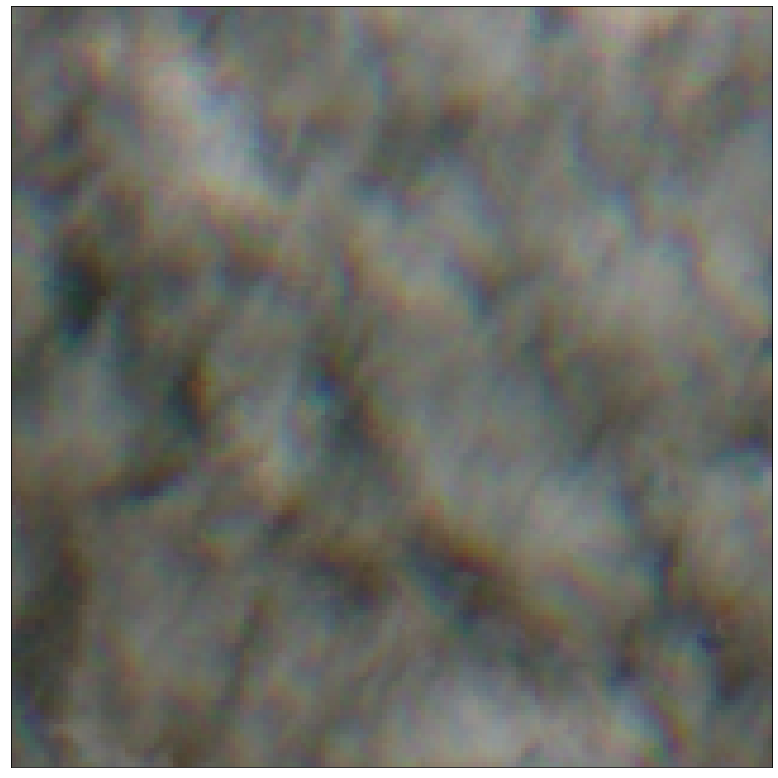

In [14]:
utilities.show_image("batch3/0340_sentinel_02.png")